In [2]:
import sys
sys.path.append('../modules')

from model import Resnet, Bottleneck
from utils import TinyImageNetDataset

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import random
from pathlib import Path

In [5]:
# Tiny Imagenet

train_mean = (0.3975, 0.4481, 0.4802)
train_std = (0.2816, 0.2689, 0.2764)

In [6]:
transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(train_mean, train_std)])
valset = TinyImageNetDataset('./data/tiny_imagenet/tiny-imagenet-200', mode = 'train', transform=transform_val)

Preloading train data...:   0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
# param

batch_size = 100

In [8]:
val_idx = np.load('./tiny_imagenet_val_idx.npy')
val_random_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False,  sampler=val_random_sampler)

In [6]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

model_save_path = './model'
model_list = sorted([x for x in Path(model_save_path).glob('*_epoch_*.pt')], key = lambda x : int(x.stem.strip('model_epoch_')))

In [ ]:
loss_history = []

for model in model_list:
    hit = 0
    all_preds = []
    all_labels = []

    net = Resnet(Bottleneck, [3, 4, 6, 3], num_classes=200).to(device)
    net = torch.nn.DataParallel(net, device_ids=[3,4,6,7]).to(device)
    net.load_state_dict(torch.load(model)['state'])

    criterion = nn.CrossEntropyLoss()
    
    net.eval()
    
    with torch.no_grad():
        val_loss = 0
        for (val_x, val_y) in tqdm(val_dataloader):
            preds = net(val_x.to(device))
            loss = criterion(preds, val_y.to(device))
            val_loss += loss
            hit += ((preds.argmax(dim=1) == val_y.to(device)).sum().item())
            
            all_preds.append(preds.argmax(dim=1))
            all_labels.append(val_y)
        
        loss_history.append(val_loss.item())
        accuracy = 100 * (hit/len(val_random_sampler))
        print(f'accuracy : {accuracy:.4f}')
        print(f'val loss : {val_loss}')
        
        del net

In [23]:
np.save('./val_loss_history', loss_history)

In [24]:
from matplotlib import pyplot as plt

In [25]:
train_loss = torch.load(model_list[-1])['loss_history']
avg_train_loss = []

for i in range(len(model_list)):
    avg_train_loss.append(train_loss[i]/(len(valset) - len(val_random_sampler)))
    
avg_val_loss = []

for i in range(len(model_list)):
    avg_val_loss.append(loss_history[i]/ len(val_random_sampler))

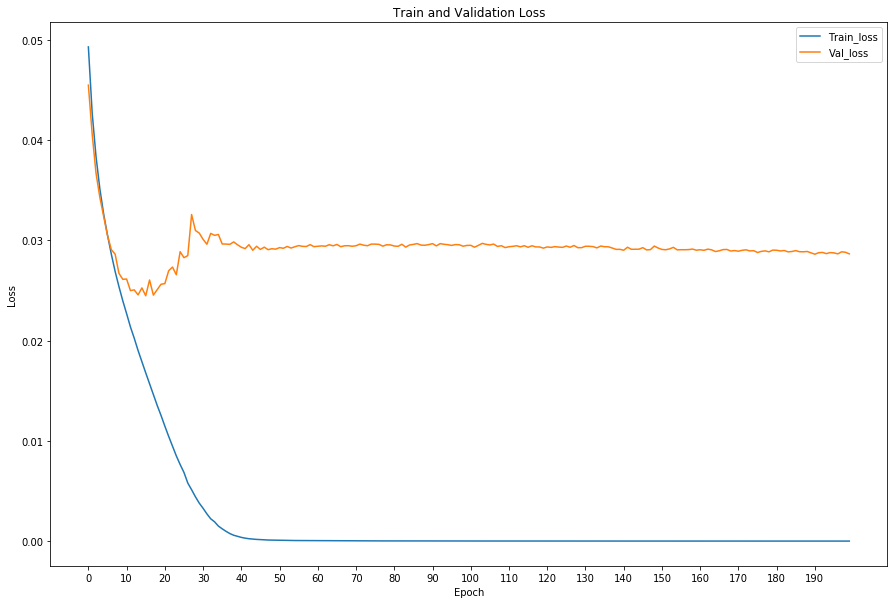

In [30]:
plt.figure(figsize = (15,10))

plt.plot([i for i in range(200)],avg_train_loss)
plt.plot([i for i in range(200)],avg_val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([i for i in range(0,200,10)])
plt.title('Train and Validation Loss')
plt.legend(['Train_loss','Val_loss'])

In [35]:
val_loss = np.load('val_loss_history.npy', allow_pickle=True)

best_model_loss = sys.float_info.max

for i in range(len(val_loss)):
    if val_loss[i].item() < best_model_loss:
        best_model_loss = val_loss[i].item()
        best_model_idx = i

In [36]:
best_model_idx

15

In [37]:
loss_history[15]

244.8196563720703

In [38]:
for i in range(len(val_loss)):
    if val_loss[i] == 294.1535949707031:
        break
    

In [39]:
i

81